# 3.5.2 Agent의 히스토리를 관리하는 방법

### 세번째 방법 : 삭제하기 전에 요약 노드 추가

- 에이전트의 히스토리를 관리해서 대화를 이어나가는 방법을 알아봅니다
- 히스토리를 관리를 위해 `checkpointer`를 사용합니다.
- `checkpointer`는 두 가지 방법을 제공합니다
    - 메모리에 저장하는 방법
    - 데이터베이스에 저장하는 방법
- 이 강의에서는 메모리에 저장하는 방법을 알아봅니다
    - 다양한 [`checkpointer`](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpointer-libraries)를 확인해보세요  

즉 checkpoint는 statesnapshot이다.

여기서는 MemorySaver를 사용

### 메시지 외에 요약 내용도 담아야 하므로 state를 수정해야한다.

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

small_llm = ChatOpenAI(model="gpt-4o-mini")

In [3]:
from langchain_core.tools import tool


@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a + b


@tool
def multiply(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a * b

In [4]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()

In [5]:
from langchain_google_community import GmailToolkit

from langchain_google_community.gmail.utils import (
    build_resource_service,
    get_gmail_credentials,
)

# Can review scopes here https://developers.google.com/gmail/api/auth/scopes
# For instance, readonly scope is 'https://www.googleapis.com/auth/gmail.readonly'
credentials = get_gmail_credentials(
    token_file="./google/gmail_token.json",
    scopes=["https://mail.google.com/"],
    client_secrets_file="./google/gmail_credentials.json",
)
api_resource = build_resource_service(credentials=credentials)
gmail_toolkit = GmailToolkit(api_resource=api_resource)
gmail_tool_list = gmail_toolkit.get_tools()

In [6]:
gmail_tool_list

[GmailCreateDraft(api_resource=<googleapiclient.discovery.Resource object at 0x136fd1ca0>),
 GmailSendMessage(api_resource=<googleapiclient.discovery.Resource object at 0x136fd1ca0>),
 GmailSearch(api_resource=<googleapiclient.discovery.Resource object at 0x136fd1ca0>),
 GmailGetMessage(api_resource=<googleapiclient.discovery.Resource object at 0x136fd1ca0>),
 GmailGetThread(api_resource=<googleapiclient.discovery.Resource object at 0x136fd1ca0>)]

In [7]:
from langchain.agents import load_tools

loaded_tool_list = load_tools(
    ["arxiv"],
)

In [8]:
import os

from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools.retriever import create_retriever_tool

embedding_function = OpenAIEmbeddings(
    model="text-embedding-3-large",
)
vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name="real_estate_tax",
    persist_directory="./real_estate_tax_collection",
)
retriever = vector_store.as_retriever(search_kwargs={"k": 3})
retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="real_estate_tax_retriever",
    description="Contains information about real estate tax up to December 2024",
)

In [9]:
from langgraph.prebuilt import ToolNode

tool_list = (
    [add, multiply, search_tool, retriever_tool] + gmail_tool_list + loaded_tool_list
)
llm_with_tools = small_llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

In [10]:
from langgraph.graph import MessagesState, StateGraph


class AgentState(MessagesState):
    summary: str


graph_builder = StateGraph(AgentState)

- (중요) 즉, MessageState를 상속 받았으므로 state 내부에 messages, summary 두개가 있다.

In [11]:
from langchain_core.messages import SystemMessage


def agent(state: AgentState) -> AgentState:
    """
    주어진 `state`에서 메시지를 가져와
    LLM과 도구를 사용하여 응답 메시지를 생성합니다.

    Args:
        state (AgentState): 메시지 기록과 요약을 포함하는 state.

    Returns:
        MessagesState: 응답 메시지를 포함하는 새로운 state.
    """
    # 메시지와 요약을 state에서 가져옵니다.
    messages = state["messages"]
    summary = state["summary"]

    # 요약이 비어있지 않으면, 요약을 메시지 앞에 추가합니다.
    if summary != "":
        messages = [
            SystemMessage(
                content=f"Here is the summary of the earlier conversation: {summary}"
            )
        ] + messages

    # LLM과 도구를 사용하여 메시지에 대한 응답을 생성합니다.
    response = llm_with_tools.invoke(messages)

    # 응답 메시지를 포함하는 새로운 state를 반환합니다.
    return {"messages": [response]}

In [12]:
def summarize_messages(state: AgentState) -> AgentState:
    """
    주어진 state의 메시지를 요약합니다.

    Args:
        state (AgentState): 메시지와 요약을 포함하는 state.

    Returns:
        AgentState: 요약된 메시지를 포함하는 딕셔너리.
    """
    # state에서 메시지와 요약을 가져옵니다.
    messages = state["messages"]
    summary = state["summary"]

    # 요약 프롬프트를 생성합니다.
    summary_prompt = f"summarize this chat history below: \n\nchat_history:{messages}"

    # 기존 요약이 있으면, 요약을 포함한 프롬프트를 생성합니다.
    if summary != "":
        summary_prompt = f"""summarize this chat history below while looking at the summary of earlier conversations
chat_history:{messages}
summary:{summary}"""

    # LLM을 사용하여 요약을 생성합니다.
    summary = small_llm.invoke(summary_prompt)

    # 요약된 메시지를 반환합니다.
    return {"summary": summary.content}

In [13]:
from langchain_core.messages import RemoveMessage


def delete_messages(state: AgentState) -> AgentState:
    """
    주어진 state에서 오래된 메시지를 삭제합니다.

    Args:
        state (AgentState): 메시지를 포함하는 state.

    Returns:
        AgentState: 삭제된 메시지를 포함하는 새로운 state.
    """
    # state에서 메시지를 가져옵니다.
    messages = state["messages"]
    # 마지막 세 개의 메시지를 제외한 나머지 메시지를 삭제합니다.
    delete_messages = [RemoveMessage(id=message.id) for message in messages[:-3]]
    # 삭제된 메시지를 포함하는 새로운 state를 반환합니다.
    return {"messages": delete_messages}

- 영상에는 수정하면서 누락된 부분입니다 (MessagesState -> AgentState)
- `should_continue`는 `summary`를 바라보지 않기 때문에 에러가 발생하지는 않습니다

In [14]:
from typing import Literal


def should_continue(state: AgentState) -> Literal["tools", "summarize_messages"]:
    """
    주어진 state에 따라 다음 단계로 진행할지를 결정합니다.

    Args:
        state (AgentState): 메시지와 도구 호출 정보를 포함하는 state.

    Returns:
        Literal['tools', 'summarize_messages']: 다음 단계로 'tools' 또는 'summarize_messages'를 반환합니다.
    """
    # state에서 메시지를 가져옵니다.
    messages = state["messages"]
    # 마지막 AI 메시지를 확인합니다.
    last_ai_message = messages[-1]

    # 마지막 AI 메시지가 도구 호출을 포함하고 있는지 확인합니다.
    if last_ai_message.tool_calls:
        # 도구 호출이 있으면 'tools'를 반환합니다.
        return "tools"

    # 도구 호출이 없으면 'summarize_messages'를 반환합니다.
    return "summarize_messages"

- `node`를 추가하고 `edge`로 연결합니다

In [15]:
graph_builder.add_node("agent", agent)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node(delete_messages)
graph_builder.add_node(summarize_messages)

In [16]:
from langgraph.graph import START, END


graph_builder.add_edge(START, "agent")
graph_builder.add_conditional_edges(
    "agent", should_continue, ["tools", "summarize_messages"]
)
graph_builder.add_edge("tools", "agent")
graph_builder.add_edge("summarize_messages", "delete_messages")
graph_builder.add_edge("delete_messages", END)

**(중요)** 히스토리 추가 부분  

히스토리 관리를 위해 `checkpointer`를 사용
- `MemorySaver`는 메모리에 저장하는 방법

In [17]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

graph = graph_builder.compile(checkpointer=checkpointer)

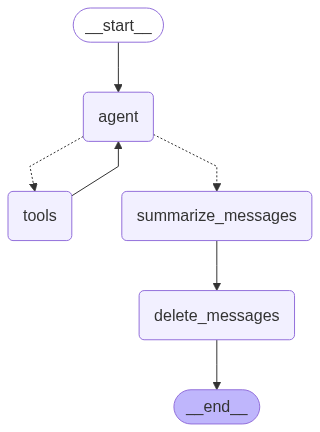

In [18]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

- `checkpointer`를 사용하는 경우, 관리를 위해 `thread_id`를 사용합니다

In [19]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "summarize_paper"}}

query = "sguys99@gmail.com으로 Attention Is All You Need 논문을 요약해서 이메일 초안을 작성해주세요"
for chunk in graph.stream(
    {"messages": [HumanMessage(query)], "summary": ""},
    config=config,
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

sguys99@gmail.com으로 Attention Is All You Need 논문을 요약해서 이메일 초안을 작성해주세요
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_c3Z7OhRjjTmKs35CQ9pjLXfB)
 Call ID: call_c3Z7OhRjjTmKs35CQ9pjLXfB
  Args:
    query: Attention Is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time on the performance of
Llama-v2 models

In [20]:
current_message_list = graph.get_state(config).values["messages"]
current_message_list

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_UYvDrYL1V5EX2wGyN8ALsAy3', 'function': {'arguments': '{"message":"안녕하세요,\\n\\n\\"Attention Is All You Need\\" 논문에 대한 요약을 공유드립니다:\\n\\n이 논문은 Transformer 모델을 기반으로 하는 딥러닝 아키텍처를 소개합니다. Transformer는 자연어 처리(NLP)에서 주로 사용되며, 특히 주목(attention) 메커니즘을 통해 이전의 RNN이나 CNN 기반 접근 방식보다 더 높은 성능을 보여주고 있습니다. \\n\\n주요 내용:\\n1. **Attention Mechanism**: 입력 데이터의 모든 단어 간의 관계를 고려하여 중요한 정보에 더 많은 가중치를 두는 메커니즘을 설명합니다.\\n2. **Self-Attention**: 입력의 각 단어가 다른 모든 단어와의 관계를 학습하여 표현력을 극대화합니다.\\n3. **Positional Encoding**: 순서 정보를 유지하기 위해 입력에 위치 정보를 추가합니다.\\n4. **Multi-Head Attention**: 여러 개의 attention heads를 사용하여 다양한 표현을 학습합니다.\\n5. **Performance**: NLP 작업에서 기존 모델들 대비 뛰어난 성능을 보여줍니다.\\n\\n이 논문은 NLP 분야에 혁신적인 변화를 가져왔으며, 다양한 후속 연구의 기초가 되었습니다.\\n\\n감사합니다.","to":["sguys99@gmail.com"],"subject":"Attention Is All You Need 논문 요약"}', 'name': 'create_gmail_draft'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 316, 'p

In [21]:
graph.get_state(config).values["summary"]

'In the chat, the user requested a summary of the "Attention Is All You Need" paper to be drafted into an email addressed to "sguys99@gmail.com." The AI executed a tool call to gather relevant information about the paper. It then summarized key aspects of the paper, which discusses the Transformer model and its attention mechanism, highlighting features like self-attention, positional encoding, and multi-head attention, emphasizing its superior performance in natural language processing tasks.\n\nThe AI created an email draft containing this summary, and confirmed that the draft was made, allowing the user to review and modify it before sending.'

In [22]:
# from langchain_core.messages import RemoveMessage

# for index, message in enumerate(current_message_list):
#     if index < len(current_message_list) - 1:
#         graph.update_state(config, {'messages': RemoveMessage(id=message.id)})

In [23]:
# current_message_list = graph.get_state(config).values['messages']
# current_message_list

In [24]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "summarize_paper"}}

update_query = "논문의 출처 URL을 포함시켜주세요"
for chunk in graph.stream(
    {"messages": [HumanMessage(update_query)]}, config=config, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

논문의 출처 URL을 포함시켜주세요
================================== Ai Message ==================================
Tool Calls:
  create_gmail_draft (call_Ut7dbjWk7DLn4Ib3z1nyg4oL)
 Call ID: call_Ut7dbjWk7DLn4Ib3z1nyg4oL
  Args:
    message: 안녕하세요,

"Attention Is All You Need" 논문에 대한 요약을 공유드립니다:

이 논문은 Transformer 모델을 기반으로 하는 딥러닝 아키텍처를 소개합니다. Transformer는 자연어 처리(NLP)에서 주로 사용되며, 특히 주목(attention) 메커니즘을 통해 이전의 RNN이나 CNN 기반 접근 방식보다 더 높은 성능을 보여주고 있습니다. 

주요 내용:
1. **Attention Mechanism**: 입력 데이터의 모든 단어 간의 관계를 고려하여 중요한 정보에 더 많은 가중치를 두는 메커니즘을 설명합니다.
2. **Self-Attention**: 입력의 각 단어가 다른 모든 단어와의 관계를 학습하여 표현력을 극대화합니다.
3. **Positional Encoding**: 순서 정보를 유지하기 위해 입력에 위치 정보를 추가합니다.
4. **Multi-Head Attention**: 여러 개의 attention heads를 사용하여 다양한 표현을 학습합니다.
5. **Performance**: NLP 작업에서 기존 모델들 대비 뛰어난 성능을 보여줍니다.

이 논문은 NLP 분야에 혁신적인 변화를 가져왔으며, 다양한 후속 연구의 기초가 되었습니다.

논문 출처: [Attention Is All You Need](https://arxiv.org/abs/1706.03762)

감사합니다.


In [25]:
graph.get_state(config).values["summary"]

'In the chat, the user asked for a summary of the "Attention Is All You Need" paper to be drafted into an email for "sguys99@gmail.com." The AI generated a comprehensive summary detailing the Transformer model, its attention mechanisms, including self-attention, positional encoding, and multi-head attention, and noted its enhanced performance in natural language processing. Following this, the AI created an email draft with the summary, confirming its creation and allowing the user to review and modify it before sending. The user later requested the inclusion of the paper\'s URL, prompting the AI to update the draft with a link to the paper.'

In [26]:
# send_query = '이메일을 전송해주세요'
# for chunk in graph.stream({'messages': [HumanMessage(send_query)]}, config=config, stream_mode='values'):
#     chunk['messages'][-1].pretty_print()

- 다시 해볼것 